In [56]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [70]:
# set number of assets (= number of qubits)
num_assets = 7
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(1999, 1, 1),
    end=datetime.datetime(2022, 12, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [71]:
mu

array([ 9.67713256e-05,  6.44084594e-05,  2.00441173e-04,  1.85492491e-04,
       -3.20649288e-04,  1.03906043e-04, -1.14116170e-04])

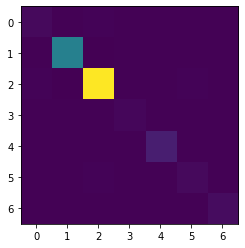

In [72]:

# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [73]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 4.4150988264838104e-05*x_0^2 - 3.2449747626551334e..., 7 variables, 1 constraints, 'Portfolio optimization'>

In [74]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [67]:
IBMQ.save_account("2377ac879cf1f5b0d4a0660ee22f22f8cdf2cb39fe123c8d67b88cf5a64257909d14e84c1a43ee83c212d805a3987f7ee3da2da42fff0e35bf6de15220d1e41b")
IBMQ.load_account()

configrc.store_credentials:WARNING:2022-10-18 00:19:11,516: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-10-18 00:19:11,706: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [76]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibm_oslo')

In [54]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

KeyboardInterrupt: 

In [ ]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

In [ ]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=qcomp, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

/Users/zesheng.li/opt/anaconda3/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:403: UserWarning: seed_simulator is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)
